# Overview of this notebook

Preliminary model fitting

# Importing Libraries and Loading Data

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
combined_df = pd.read_csv('ProcessedData/PreChoice_CombinedBehavioralEyeTrackingData.csv', index_col='Unnamed: 0')

In [3]:
combined_df.keys()

Index(['Subj', 'Trial', 'Game', 'Stim11', 'Stim12', 'Stim13', 'Stim21',
       'Stim22', 'Stim23', 'Stim31', 'Stim32', 'Stim33', 'Choice', 'Chosen1',
       'Chosen2', 'Chosen3', 'Unchosen1', 'Unchosen2', 'Unchosen3',
       'Unchosen4', 'Unchosen5', 'Unchosen6', 'Outcome', 'Dim', 'Feat',
       'CenterDim', 'CenterFeat', 'Correct', 'LearnedFeat', 'PoL', 'RT',
       'WithinGameTrial', 'Adult', 'Age', 'Block', 'Feature1', 'Feature2',
       'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8',
       'Feature9', 'Feature10', 'TotalLookingTime', 'FeatureEntropy',
       'Animals', 'Landscapes', 'Objects', 'DimensionEntropy'],
      dtype='object')

In [4]:
# split into adult and adolescent
adole_combined_df = combined_df[combined_df['Adult'] == False].fillna(0)
adult_combined_df = combined_df[combined_df['Adult']].fillna(0)

# Summary Statistics

In [5]:
summary_df = pd.DataFrame()

In [6]:
combined_df.groupby('Subj')['LearnedFeat'].describe()

,count,unique,top,freq
Subj,,,,
23,400,1,True,400
26,400,1,True,400
27,400,1,False,400
28,400,1,True,400
29,400,1,False,400
30,400,1,False,400
31,400,1,True,400
34,400,1,False,400
35,400,1,False,400


In [7]:
summary_df['Age'] = combined_df.groupby('Subj')['Age'].describe()['mean']
summary_df['Mean_RT'] = combined_df.groupby('Subj')['RT'].describe()['mean']
summary_df['Mean_Feature1'] = combined_df.groupby('Subj')['Feature1'].describe()['mean']
summary_df['Mean_Feature2'] = combined_df.groupby('Subj')['Feature2'].describe()['mean']
summary_df['Mean_Feature3'] = combined_df.groupby('Subj')['Feature3'].describe()['mean']
summary_df['Mean_Feature4'] = combined_df.groupby('Subj')['Feature4'].describe()['mean']
summary_df['Mean_Feature5'] = combined_df.groupby('Subj')['Feature5'].describe()['mean']
summary_df['Mean_Feature6'] = combined_df.groupby('Subj')['Feature6'].describe()['mean']
summary_df['Mean_Feature7'] = combined_df.groupby('Subj')['Feature7'].describe()['mean']
summary_df['Mean_Feature8'] = combined_df.groupby('Subj')['Feature8'].describe()['mean']
summary_df['Mean_Feature9'] = combined_df.groupby('Subj')['Feature9'].describe()['mean']
summary_df['Mean_Feature10'] = combined_df.groupby('Subj')['Feature10'].describe()['mean']
summary_df['Mean_Animals'] = combined_df.groupby('Subj')['Animals'].describe()['mean']
summary_df['Mean_Landscapes'] = combined_df.groupby('Subj')['Landscapes'].describe()['mean']
summary_df['Mean_Objects'] = combined_df.groupby('Subj')['Objects'].describe()['mean']
summary_df['Mean_DimensionEntropy'] = combined_df.groupby('Subj')['DimensionEntropy'].describe()['mean']
summary_df['Mean_FeatureEntropy'] = combined_df.groupby('Subj')['FeatureEntropy'].describe()['mean']
summary_df['Mean_LookingTime'] = combined_df.groupby('Subj')['TotalLookingTime'].describe()['mean']
summary_df['Mean_Correct'] = combined_df.groupby('Subj')['Correct'].describe()['mean']
summary_df['LearnedFeat'] = combined_df.groupby('Subj')['LearnedFeat'].describe()['top']
summary_df = summary_df.reset_index()

In [70]:
summary_df.to_csv('ProcessedData/SummaryStatisticsbySubject.csv')

In [8]:
entropy_col = []
for index, row in summary_df.iterrows():
    features = [row.Mean_Feature1, row.Mean_Feature2, row.Mean_Feature3, row.Mean_Feature4, row.Mean_Feature5, row.Mean_Feature6, row.Mean_Feature7, row.Mean_Feature8, row.Mean_Feature9]
    features = [feature/sum(features) for feature in features]
    curr_entropy = entropy(features, base=9)
    entropy_col.append(curr_entropy)
summary_df['MeanFeatureEntropy'] = entropy_col

entropy_col = []
for index, row in summary_df.iterrows():
    features = [row.Mean_Animals, row.Mean_Landscapes, row.Mean_Objects]
    features = [feature/sum(features) for feature in features]
    curr_entropy = entropy(features, base=3)
    entropy_col.append(curr_entropy)
summary_df['MeanDimensionEntropy'] = entropy_col

In [66]:
summary_df[['Subj']] = summary_df[['Subj']].astype(int)

## Mean Looking Times across Features

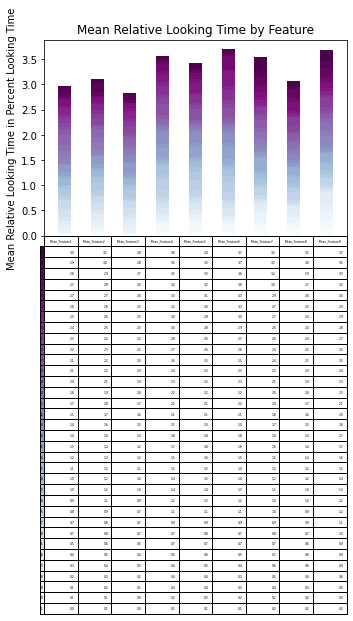

In [235]:
data = summary_df[['Subj','Mean_Feature1', 'Mean_Feature2','Mean_Feature3',
                    'Mean_Feature4','Mean_Feature5', 'Mean_Feature6',
                    'Mean_Feature7', 'Mean_Feature8', 'Mean_Feature9']].set_index('Subj')

# data_T = data.transpose()

rows = np.array(data.index.values)
columns = np.array(data.keys())
data.reset_index(drop=True)
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    curr_row = np.array(data.iloc[row])
    plt.bar(index, curr_row, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + curr_row
    cell_text.append(['%1.1f' % x for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Mean Relative Looking Time in Percent Looking Time")
plt.xticks([])
plt.title('Mean Relative Looking Time by Feature')

plt.show()

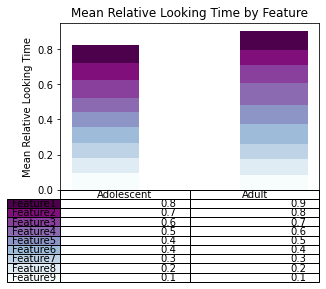

In [263]:
data = summary_df[['Subj','Age', 'Mean_Feature1', 'Mean_Feature2','Mean_Feature3',
                    'Mean_Feature4','Mean_Feature5', 'Mean_Feature6',
                    'Mean_Feature7', 'Mean_Feature8', 'Mean_Feature9']]

data.loc[data['Age'] >= 18,'AgeGroup'] = 'Adult'
data.loc[data['Age'] < 18,'AgeGroup'] = 'Adolescent'

plot_data = pd.DataFrame()
plot_data['Feature1'] = data.groupby('AgeGroup')['Mean_Feature1'].describe()['mean']
plot_data['Feature2'] = data.groupby('AgeGroup')['Mean_Feature2'].describe()['mean']
plot_data['Feature3'] = data.groupby('AgeGroup')['Mean_Feature3'].describe()['mean']
plot_data['Feature4'] = data.groupby('AgeGroup')['Mean_Feature4'].describe()['mean']
plot_data['Feature5'] = data.groupby('AgeGroup')['Mean_Feature5'].describe()['mean']
plot_data['Feature6'] = data.groupby('AgeGroup')['Mean_Feature6'].describe()['mean']
plot_data['Feature7'] = data.groupby('AgeGroup')['Mean_Feature7'].describe()['mean']
plot_data['Feature8'] = data.groupby('AgeGroup')['Mean_Feature8'].describe()['mean']
plot_data['Feature9'] = data.groupby('AgeGroup')['Mean_Feature9'].describe()['mean']

plot_data = plot_data.transpose()

rows = np.array(plot_data.index.values)
columns = np.array(plot_data.keys())
plot_data.reset_index(drop=True)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    curr_row = np.array(plot_data.iloc[row])
    plt.bar(index, curr_row, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + curr_row
    cell_text.append(['%1.1f' % x for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.3, bottom=0.3)

plt.ylabel("Mean Relative Looking Time")
plt.xticks([])
plt.title('Mean Relative Looking Time by Feature')

plt.show()

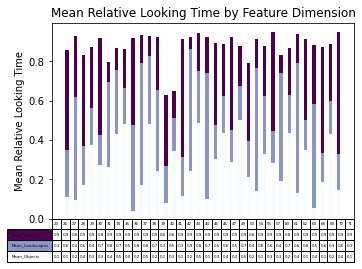

In [267]:
data = summary_df[['Subj','Mean_Animals', 'Mean_Landscapes','Mean_Objects']].set_index('Subj')

data = data.transpose()

rows = np.array(data.index.values)
columns = np.array(data.keys())
data.reset_index(drop=True)
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    curr_row = np.array(data.iloc[row])
    plt.bar(index, curr_row, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + curr_row
    cell_text.append(['%1.1f' % x for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Mean Relative Looking Time")
plt.xticks([])
plt.title('Mean Relative Looking Time by Feature Dimension')

plt.show()

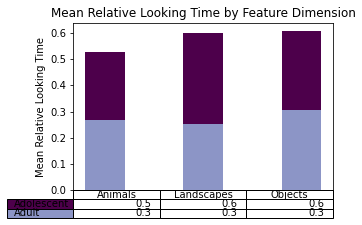

In [271]:
data = summary_df[['Subj','Age', 'Mean_Animals', 'Mean_Landscapes','Mean_Objects']]

data.loc[data['Age'] >= 18,'AgeGroup'] = 'Adult'
data.loc[data['Age'] < 18,'AgeGroup'] = 'Adolescent'

plot_data = pd.DataFrame()
plot_data['Animals'] = data.groupby('AgeGroup')['Mean_Animals'].describe()['mean']
plot_data['Landscapes'] = data.groupby('AgeGroup')['Mean_Landscapes'].describe()['mean']
plot_data['Objects'] = data.groupby('AgeGroup')['Mean_Objects'].describe()['mean']

# plot_data = plot_data.transpose()

rows = np.array(plot_data.index.values)
columns = np.array(plot_data.keys())
plot_data.reset_index(drop=True)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0.5, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    curr_row = np.array(plot_data.iloc[row])
    plt.bar(index, curr_row, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + curr_row
    cell_text.append(['%1.1f' % x for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.3, bottom=0.3)

plt.ylabel("Mean Relative Looking Time")
plt.xticks([])
plt.title('Mean Relative Looking Time by Feature Dimension')

plt.show()

# Fitting to Linear Models to See Trends

Slight Correlations between:
- RT*DimensionEntropy
- RT*FeatureEntropy
- Mean_LookingTime*Mean_RT
- Age*Mean_Feature10
- Age*Mean_Feature6

Sanity Check:
- Mean_DimensionEntropy*Mean_FeatureEntropy

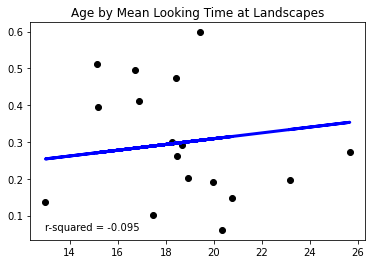

In [228]:
X = np.array(summary_df.Age).reshape((-1,1))
y = np.array(summary_df.Mean_Objects)

shuffler = np.random.permutation(len(X))

X_shuffled = X[shuffler]
y_shuffled = y[shuffler]

# Split the data into training/testing sets
X_train, X_test = np.split(X_shuffled,2)

# Split the targets into training/testing sets
y_train, y_test = np.split(y_shuffled,2)

# fit to model and predict on test set
model = LinearRegression().fit(X=X_train, y=y_train)
y_pred = model.predict(X_test)

# plot
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (min(X_test), min(y_test)))
plt.title("Age by Mean Looking Time at Landscapes")
plt.show()

# Fitting to Reinforcement Learning Models